In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import random
import sys

from imgaug import augmenters as iaa
from utils import (
    draw_image, iou, map_iou, parse_dataset, get_dicom_fps, predict_submit
)

In [17]:
ROOT_DIR = os.path.abspath('..')

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [18]:
MODEL_DIR = os.path.join(ROOT_DIR, 'model')
RAWDATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw')
PREPROCESS_DIR = os.path.join(ROOT_DIR, 'data', 'preprocess')
TRAIN_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_train_images')
TEST_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_test_images')

In [19]:
df_train = pd.read_csv(os.path.join(PREPROCESS_DIR, 'train.csv'))
df_train.head(5)

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,370.5,341.5,Lung Opacity


In [20]:
image_fps, image_annotations = parse_dataset(TRAIN_DICOM_DIR, anns=df_train)

In [21]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # Notes: https://github.com/mdai/ml-lessons/issues/2
    # Comment following if no GPU supported.
    RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

In [22]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [23]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
# image_fps_list = list(image_fps[:100]) 
image_fps_list = image_fps
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print('train len: {}, val len: {}'.format(len(image_fps_train), len(image_fps_val)))

train len: 23115, val len: 2569


In [24]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

# Training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [25]:
annotations = [d['annotations'] for d in dataset_train.image_info]
has_pneumonias = [a for a in annotations if a[0]['Target'] == 1]

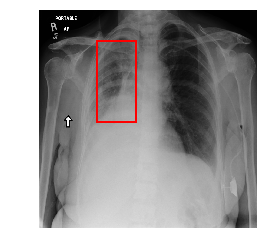

In [26]:
has_pneumonia = random.choice(has_pneumonias)
patient_id = has_pneumonia[0].patientId
_, ax = plt.subplots()
draw_image(df_train, patient_id, ax, TRAIN_DICOM_DIR)

In [27]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [28]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [29]:
NUM_EPOCHS = 3

# Train Mask-RCNN Model 
import warnings
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)
model_path = model.find_last()


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/abaw/repos/self/kaggle-rsna-pneumonia-detection-challenge/model/pneumonia20180911T2234/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Batc

In [30]:
# model_path = '/home/abaw/repos/self/kaggle-rsna-pneumonia-detection-challenge/model/pneumonia20180911T1645'
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/abaw/repos/self/kaggle-rsna-pneumonia-detection-challenge/model/pneumonia20180911T2234/mask_rcnn_pneumonia_0003.h5
Re-starting from epoch 3


In [16]:
# set color for class# set c 
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

0

*** No instances to display *** 

0

*** No instances to display *** 


*** No instances to display *** 

0

*** No instances to display *** 

0

*** No instances to display *** 


*** No instances to display *** 

0

*** No instances to display *** 


*** No instances to display *** 



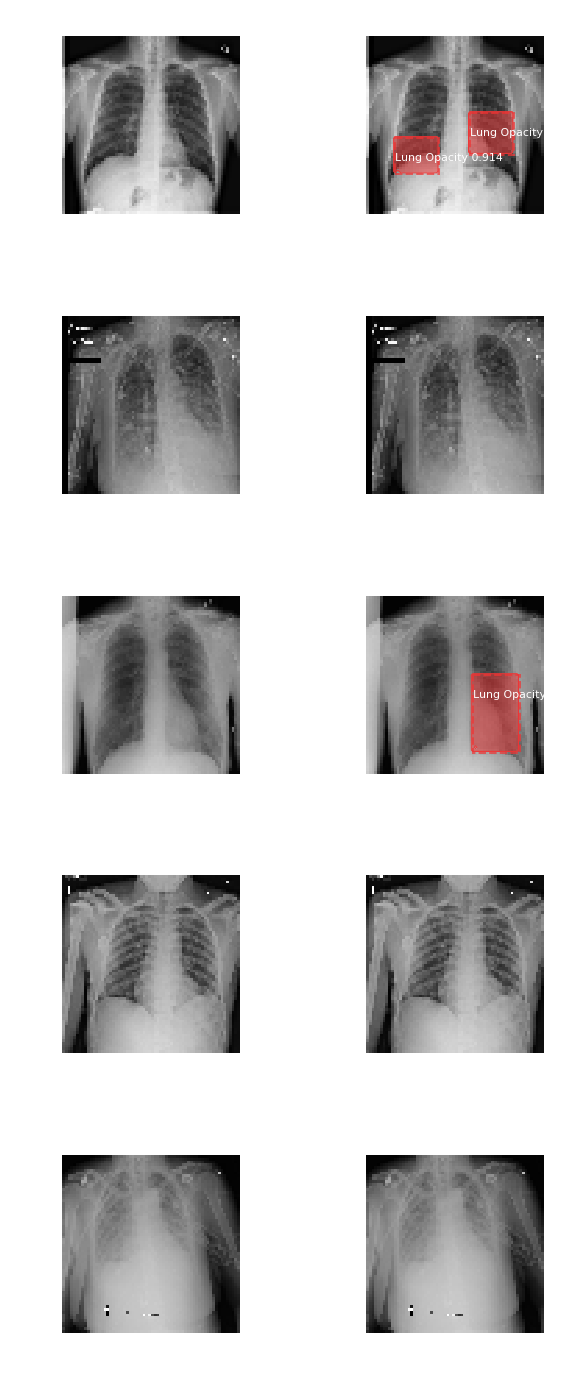

In [17]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(5):
# for i in range(1):

    idx = random.choice(dataset.image_ids)
    patient_id = dataset.image_info[idx]['annotations'][0]['patientId']
#     _, ax = plt.subplots()
#     print(df_train[df_train.patientId == patient_id]['Target'])
#     draw_image(df_train, patient_id, ax, TRAIN_DICOM_DIR)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               idx, use_mini_mask=False)
    
    print(len(gt_bbox))
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [46]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

    # Predict for validation
    results = model.detect([image], verbose=0)
    r = results[0]
    
    if len(gt_class_id) == 0 and len(r['class_ids']) == 0:
        continue
    elif len(gt_class_id) != 0 and len(r['class_ids']) != 0:
        
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
    else:
        AP = 0

    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.05855855856065613


In [32]:
image_ids = dataset_val.image_ids
IoUs = []
for image_id in image_ids:
    # Load ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
    # Predict for validation
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Calcuate IoU
    iou = map_iou(gt_bbox, r['rois'], r['scores'])
    if iou is not None:
        IoUs.append(iou)
    
print("mIoUs:", np.mean(IoUs))

mIoUs:  0.08686919341216216


In [30]:
"""
EPOCH = 3
mIoUs:  0.07378275185652233

EPOCH = 1
mIoUs:  0.03346132400648824
"""

'\nEPOCH = 3\nmIoUs:  0.07378275185652233\n\nEPOCH = 1\nmIoUs:  0.03346132400648824\n'

In [34]:
test_image_fps = get_dicom_fps(TEST_DICOM_DIR)

In [44]:
def predict_submit(model, image_filepaths, filepath, min_conf=.98):
    data = []
    for image_filepath in image_filepaths:
        ds = pydicom.read_file(image_filepath)
        image = ds.pixel_array

        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)

        patient_id = os.path.splitext(os.path.basename(image_filepath))[0]

        results = model.detect([image])
        r = results[0]

        assert(len(r['rois']) == len(r['class_ids']) == len(r['scores']))

        pred_str = ''
        for i in range(len(r['rois'])):
            score = r['scores'][i]
            if score > min_conf:
                roi = r['rois'][i]
                pred_str = ' '.join([str(v) for v in [
                    pred_str, score, roi[1], roi[0], roi[3]-roi[1], roi[2]-roi[0]
                ]])
        data.append([patient_id, pred_str])

    df_submit = pd.DataFrame(data=data, columns=['patientId', 'PredictionString'])
    df_submit.to_csv(filepath, index=False)

    return df_submit

In [45]:
filename = '/home/abaw/repos/self/kaggle-rsna-pneumonia-detection-challenge/model/pneumonia20180911T2234/submit.csv'
predict_submit(model, test_image_fps, filename)

,patient_id,pred_string
0,2721b917-061a-489b-8580-db98f0e80d60,
1,224c3686-d481-46f9-8a3a-4e492ba3363f,
2,248212c6-2326-47ea-9976-6cbaa9c7ae3e,
3,c003fdb7-d3ca-4295-92a8-03b32bffc780,
4,21b97415-1275-4483-9705-af9174fc2b4f,
5,133a1f56-1ab0-4df7-8e1b-4a6293934f3a,
6,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,
7,2e566084-386d-48a6-beb2-8b28732371e7,
8,26f86e0f-62b6-44c4-8463-4d0bd24df95b,
9,23aa6468-59f9-4ace-b656-9fea8d64764a,
